# Preparação das Bases

In [22]:
# Importa bibliotecas
import requests
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.ensemble import GradientBoostingClassifier

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN

In [5]:
# Importa Base de Dados
df_ml = pd.read_csv('C:/Users/CB517RL/OneDrive - EY/Desktop/Projeto final/Grupo2DnA/bases/Prata/clean.csv', sep = ";")
df_ml.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Substitui variaveis descritivas
df_ml['id_geography'] = df_ml['Geography'].replace({'France': 0, 'Spain': 1, 'Germany': 2})
df_ml['id_gender'] = df_ml['Gender'].replace({'Female': 0, 'Male': 1})

In [9]:
# Exclui colunas que nao serao utilizadas no modelo
df_ml = df_ml.drop(columns=["Geography", "Gender"])

# Construção dos Modelos

### Definição da variáveis de treino e de teste

In [10]:
# definindo a aleatoriedade para separação das bases de treino e de teste
SEED = 5
np.random.seed(SEED)

In [11]:
# Separa os dados em features e target
x = df_ml[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "id_geography", "id_gender"]] # Features
y = df_ml["Exited"] # Target variable

Base possue grande desproporcionalidade entre os valores de churn positivo e churn negativo, por isso o balanceamento é necessário.

In [12]:
# Usa SMOTE() para balancear a divisao entre número de churn positivos e de negativos
treino_x, treino_y = SMOTE().fit_resample(x, y)

In [13]:
print("Contagem de classes antes do balanceamento:")
print(y.value_counts())
 
print("\nContagem de classes após o balanceamento:")
print(treino_y.value_counts())

Contagem de classes antes do balanceamento:
Exited
0    7934
1    2017
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Exited
1    7934
0    7934
Name: count, dtype: int64


In [14]:
# Divide de variaveis de treino e de teste (features e target)
treino_x, teste_x, treino_y, teste_y = train_test_split(treino_x, 
                                                        treino_y, 
                                                        random_state=SEED, 
                                                        test_size=0.3)

In [15]:
# Escala as duas variáveis
scaler = MinMaxScaler(feature_range=(0, 1))
treino_x = scaler.fit_transform(treino_x)
teste_x = scaler.fit_transform(teste_x)

### XGBOOST

In [16]:
# Modelo XGBOOST
xgboost = XGBClassifier()

In [17]:
# Hiperparâmetros XGBOOST utilizando BayesSearchCV
param_space_xgboost = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 50),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(0, 5)
}

# Instância do BayesSearchCV
bayes_xgboost = BayesSearchCV(
    estimator=xgboost,
    search_spaces=param_space_xgboost,
    n_iter=50,    
    cv=3,         
    scoring='accuracy',  
    n_jobs=-1     
)


In [18]:
# Rodando modelo com hiperparametros definidos
bayes_xgboost.fit(treino_x, treino_y)
previsoes_xgboost = bayes_xgboost.predict(teste_x)

In [19]:
# Acuracia xgboost
acuracia_xgboost = accuracy_score(teste_y, previsoes_xgboost) * 100
print("A acurácia foi de: %.2f%%" % acuracia_xgboost)

A acurácia foi de: 86.47%


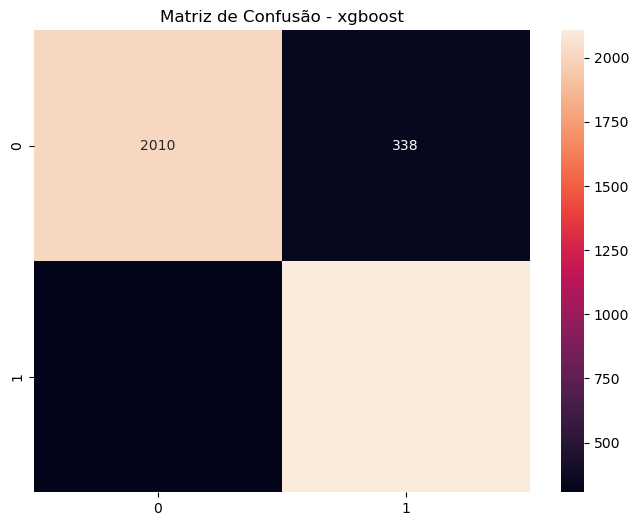

In [20]:
# Matriz de confusao XGBOOST
y_true_xgboost = teste_y
y_pred_xgboost = previsoes_xgboost
matriz_de_confusao_xgboost = confusion_matrix(y_true_xgboost, y_pred_xgboost) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_xgboost, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - xgboost')
plt.show()

In [21]:
matriz_de_confusao_xgboost

array([[2010,  338],
       [ 306, 2107]], dtype=int64)

In [22]:
# Recall XGBOOST
recall_xgboost = recall_score(teste_y, previsoes_xgboost) * 100
print("A taxa de Recall do xgboost foi de: %.2f%%" % recall_xgboost)

A taxa de Recall do xgboost foi de: 87.32%


# Resultado do modelo

In [23]:
df_inverse = scaler.inverse_transform(teste_x)

In [24]:
previsoes_xgboost

array([0, 0, 0, ..., 0, 0, 0])

In [25]:

df_result = pd.DataFrame(df_inverse, columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "id_geography", "id_gender"])
df_result['previsoes'] = previsoes_xgboost
df_result.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id_geography,id_gender,previsoes
0,681.0,29.0,2.0,148143.840000,1.0,1.0,1.0,52021.390000,0.0,0.0,0
1,739.0,37.0,7.0,104960.460000,1.0,0.0,1.0,80883.820000,0.0,1.0,0
2,597.0,35.0,0.0,127510.990000,1.0,1.0,1.0,155356.340000,1.0,1.0,0
3,493.0,44.0,7.0,143684.302485,2.0,1.0,0.0,141391.209481,1.0,0.0,1
4,828.0,42.0,10.0,0.000000,1.0,1.0,1.0,186071.140000,1.0,1.0,0


In [26]:
churn = df_result[df_result['previsoes'] == 1]
churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id_geography,id_gender,previsoes
3,493.0,44.0,7.0,143684.302485,2.0,1.0,0.0,141391.209481,1.0,0.0,1
8,589.0,42.0,3.0,0.000000,1.0,1.0,0.0,85280.322756,0.0,0.0,1
9,539.0,53.0,3.0,0.000000,1.0,1.0,0.0,49572.912689,0.0,0.0,1
10,633.0,32.0,8.0,108705.687514,1.0,0.0,0.0,179391.055309,1.0,1.0,1
11,650.0,50.0,3.0,126579.260257,1.0,0.0,0.0,17439.864939,2.0,1.0,1


In [44]:
# Salvando resultados do modelo
df_result.to_csv('df_previsoes_gerais.csv')
churn.to_csv('df_previsoes_positivas.csv')

# Integração EYQ

In [23]:
# More secure way
# incubator_endpoint = os.getenv("EYQ_INCUBATOR_ENDPOINT")
# incubator_key = os.getenv("EYQ_INCUBATOR_KEY")
# Less secure way
incubator_endpoint = "https://eyqincubator.america.fabric.ey.com/eyq/canadaeast/api/"
incubator_key = "toNx9GPyvXRB9C6sDC8G47XAO2IKGeZV"
api_version = "2023-05-15"
model = "gpt-4"  # Replace with desired model
headers = {
    "x-api-key": incubator_key
}
query_params = {
    "api-version": api_version
}

 
def chat(prompt):
    body = {
        "messages":[
            {"role": "system", "content":"""
            Você é um assistente de um banco e tem como trabalho evitar que clientes com alta porcentagem de churn deixem de ser clientes. Você pode oferecer até 20 por cento de desconto  para todos os clientes que optarem por sair do banco.  Fale com uma linguagem amigavel porém profissional, mostre para o cliente que estamos dispostos a atender suas necessidades.
            Além dos 20 por cento de desconto personalize a proposta para clientes que possuirem o perfil abaixo e inclua na proposta os seguintes beneficios:
            
            Faixa Etária Para a faixa de 33 a 47  ofereça  10 por cento de desconto em planos de aposentadoria e  educação dos filhos.
            Influência do Gênero:  Se forem mulheres ofereça um convite para nossos workshops sobre finanças pessoais, empreendedorismo e liderança exclusivo para mulheres. também ofereça inclusão no nosso clube de beneficios como descontos em lojas parceiras, serviços de bem-estar e beleza, e programa de cashback
            Localização Geográfica: ofereça inclusão no nosso clube de beneficios como descontos em lojas parceiras Locais, e programa de cashback
            Atividade do Cliente: Incentive clientes não ativos com programas de fidelidade, benefícios exclusivos como cashback e comunicação aprimorada sobre os serviços bancários.
            Pontuação de Crédito: Clientes com Score até 350 oferecer gratuitamente um curso de educação financeira."""},
            {"role":"user","content": prompt}
        ]
    }
 
    full_path = incubator_endpoint + "/openai/deployments/" + model + "/chat/completions"
 
    response = requests.post(full_path, json=body, headers=headers, params=query_params)
 
    response = response.json()
 
    body["messages"].append({"role": "system", "content": response["choices"][0]["message"]["content"]})
 
    return response["choices"][0]["message"]["content"]

In [24]:
# import pandas as pd
df_previsoes_positivas = pd.read_csv('C:/Users/CB517RL/OneDrive - EY/Desktop/Projeto final/Grupo2DnA/bases/Ouro/df_previsoes_positivas.csv')
df_previsoes_positivas = df_previsoes_positivas.drop('Unnamed: 0', axis=1)
df_previsoes_positivas.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id_geography,id_gender,previsoes
0,493.0,44.0,7.0,143684.302485,2.0,1.0,0.0,141391.209481,1.0,0.0,1
1,589.0,42.0,3.0,0.000000,1.0,1.0,0.0,85280.322756,0.0,0.0,1
2,539.0,53.0,3.0,0.000000,1.0,1.0,0.0,49572.912689,0.0,0.0,1
3,633.0,32.0,8.0,108705.687514,1.0,0.0,0.0,179391.055309,1.0,1.0,1
4,650.0,50.0,3.0,126579.260257,1.0,0.0,0.0,17439.864939,2.0,1.0,1


In [6]:
chat(f"""
Personalize uma mensagem em 10 linhas para o usuario com os seguintes dados:
     {df_previsoes_positivas.iloc[0:9]}
     """)

'Caro Cliente,\n\nSabemos que você está considerando deixar o banco. Gostaríamos de oferecer a você uma série de benefícios. Primeiramente, oferecemos um desconto de 20% para você permanecer conosco.\n\nComo você tem entre 33 e 47 anos, também oferecemos um desconto adicional de 10% em planos de aposentadoria e na educação dos filhos. E como você é uma mulher ativa, gostaríamos de convidá-la para os nossos workshops sobre finanças pessoais, empreendedorismo e liderança. \n\nTambém queremos lhe incluir no nosso clube de benefícios. Você terá descontos nas lojas locais parceiras, serviços de bem-estar e beleza. Queremos reativar sua atividade conosco através de um programa de fidelidade e benefícios exclusivos como cashback.\n\nSua avaliação de crédito é até 350, assim, gostaríamos de oferecer gratuitamente um curso de educação financeira. Esperamos que você considere permanentemente essa decisão. \n\nEstamos aqui para atender às suas necessidades. \n\nEstamos te esperando!'

In [28]:
# Gerando mensagem para os clientes que foram identificados como possíveis churn
mensagens = []
for i in range(1, 10):
    user = df_previsoes_positivas.iloc[i]
    mensagem = chat(f"Personalize uma mensagem com até 10 linhas para o usuario com os seguintes dados: {user}")
    print(mensagem)
    mensagens.append(mensagem)

Caro cliente, percebemos que você está considerando deixar nosso banco e gostaríamos de oferecer um desconto de 20% para você continuar conosco. Notamos que você se encontra na faixa etária de 33 a 47 anos, por isso, estamos oferecendo um adicional de 10% de desconto em nossos planos de aposentadoria e educação para os filhos. 

Sendo uma de nossas valiosas clientes do sexo feminino, gostaríamos de convidá-la para nossos workshops exclusivos sobre finanças pessoais, empreendedorismo e liderança. Incluiremos você em nosso clube de benefícios, com descontos em lojas parceiras, além de serviços de bem-estar e beleza e um programa de cashback.

Sabemos que você não tem sido tão ativa em nossos serviços, por isso, gostaríamos de incentivá-la com nossos programas de fidelidade, incluindo benefícios exclusivos como cash back e uma comunicação aprimorada sobre nossos serviços bancários. 

Adicionalmente, estamos oferecendo um curso gratuito de educação financeira para te apoiar ainda mais! Jun

In [31]:
df_mensagens = pd.DataFrame(mensagens)
df_mensagens.head(10)

,0
0,"Caro cliente, percebemos que você está conside..."
1,"Caro cliente, entendemos suas preocupações e q..."
2,"Caro cliente, entendemos que você está conside..."
3,"Caro cliente, notamos que você esteve consider..."
4,"Caro cliente, percebemos que você está pensand..."
5,"Prezado cliente,\n\nOuvimos suas preocupações ..."
6,"Olá querida cliente,\n\nPercebemos que você te..."
7,"Caro Cliente,\n\nEntendemos que você pode esta..."
8,"Prezado(a) Cliente,\n\nEntendemos que nosso ba..."


In [34]:
# Salvando mensagens geradas
# df_mensagens.to_csv('df_mensagens-geradas.csv')